# Qestion 9

In [36]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

In [59]:
s_e = 1

def importance(s1, s2, y=1): 
    pr = 1-stats.norm(s1-s2, s_e**0.5).cdf(0) if y>0 else stats.norm(s1-s2, s_e**0.5).cdf(0)
    return pr

## Gibbs sampling

In [60]:
num_samples = 5000
drops = 1000

def approx_gaussian(data, importances): 
    mean = np.average(data, weights=importances)
    variance = np.average((data-mean)**2, weights=importances)
    return mean, variance

In [61]:
# prior
m1, m2 = 0, 0
v1, v2 = 1, 1

# observed results
ys = [1,]

for y in ys: 
    posterior = []
    post_weights = []
    s1 = 0
    s1_w = 1

    for _ in range(num_samples):
        s2 = stats.norm.rvs(m2, v2**0.5)
        s2_w = importance(s1, s2, y)
        
        posterior.append((s1, s2))
        post_weights.append((s1_w, s2_w))

        s1 = stats.norm.rvs(m1, v1**0.5)
        s1_w = importance(s1, s2, y)

    posterior = np.array(posterior)
    post_weights = np.array(post_weights)
    
    m1, v1 = approx_gaussian(posterior[drops:, 0], post_weights[drops:, 0])
    m2, v2 = approx_gaussian(posterior[drops:, 1], post_weights[drops:, 1])
    print("=======")
    print(f"S1: N({m1}, {v1})")
    print(f"S2: N({m2}, {v2})")
    
m1_gibbs = m1
v1_gibbs = v1
m2_gibbs = m2
v2_gibbs = v2

S1: N(0.4381749546759382, 0.8138967753198559)
S2: N(-0.4586859938101151, 0.7720202457278948)


## Message-passing & moment-matching

In [62]:
def post_s1(mu1, mu2, v1, v2, s_e, y):
    b = np.sign(y) * np.sqrt(2 * (v1 + v2 + s_e) / np.pi)
    beta = (v1 + v2 + s_e) * (1 - 2 / np.pi)
    
#     alpha = beta * (v1 + v2 + s_e) / (v1 + v2 + s_e - beta)
#     a = alpha * (b / beta - (mu1 - mu2) / (v1 + v2 + s_e))
    a = (b - (mu1 - mu2) * (1 - 2 / np.pi)) * np.pi / 2
    alpha = (v1 + v2 + s_e) * (np.pi / 2 - 1)
    
    m1 = (mu1 * (s_e + v2 + alpha) + (mu2 + a) * s_e) / (s_e + v2 + alpha + v1)
    v1 = v1 * (s_e + v2 + alpha) / (v1 + s_e + v2 + alpha)
    return m1, v1

def post_s2(mu1, mu2, v1, v2, s_e, y):
    b = np.sign(y) * np.sqrt(2 * (v1 + v2 + s_e) / np.pi)
    beta = (v1 + v2 + s_e) * (1 - 2 / np.pi)
    
#     alpha = beta * (v1 + v2 + s_e) / (v1 + v2 + s_e - beta)
#     a = alpha * (b / beta - (mu1 - mu2) / (v1 + v2 + s_e))
    a = (b - (mu1 - mu2) * (1 - 2 / np.pi)) * np.pi / 2
    alpha = (v1 + v2 + s_e) * (np.pi / 2 - 1)
    
    m2 = (mu2 * (s_e + v1 + alpha) + (mu1 - a) * s_e) / (s_e + v1 + alpha + v2)
    v2 = v2 * (s_e + v1 + alpha) / (v2 + s_e + v1 + alpha)
    return m2, v2

In [63]:
# prior
m1, m2 = 0, 0
v1, v2 = 1, 1

# observed results
ys = [1,]

for y in ys:     
    m1_new, v1_new = post_s1(m1, m2, v1, v2, s_e, y)
    m2_new, v2_new  = post_s2(m1, m2, v1, v2, s_e, y)
    print("=======")
    print(f"S1: N({m1_new}, {v1_new})")
    print(f"S2: N({m2_new}, {v2_new})")
    
m1_mp = m1_new
v1_mp = v1_new
m2_mp = m2_new
v2_mp = v2_new

S1: N(0.4606588659617807, 0.7877934092108062)
S2: N(-0.4606588659617807, 0.7877934092108062)


### Result for win

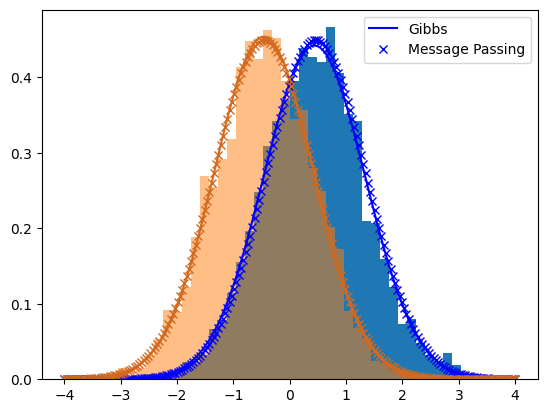

In [65]:
plt.hist(posterior[drops:,0], density=True, weights=post_weights[drops:,0], bins=50, range=(-4, 4))
plt.hist(posterior[drops:,1], density=True, weights=post_weights[drops:,1], bins=50, range=(-4, 4), alpha=0.5)

xs = np.linspace(-4, 4, 200)
gaussian1_gibbs = stats.norm(m1_gibbs, v1_gibbs**0.5).pdf(xs)
gaussian2_gibbs = stats.norm(m2_gibbs, v2_gibbs**0.5).pdf(xs)
plt.plot(xs, gaussian1_gibbs, color='blue', label='Gibbs')
plt.plot(xs, gaussian2_gibbs, color='chocolate')

gaussian1_mp = stats.norm(m1_mp, v1_mp**0.5).pdf(xs)
gaussian2_mp = stats.norm(m2_mp, v2_mp**0.5).pdf(xs)
plt.plot(xs, gaussian1_mp, 'x', color='blue', label='Message Passing')
plt.plot(xs, gaussian2_mp, 'x', color='chocolate')

plt.legend()

### we see that two types of line, posterior from Gibbs sampling and from Moment-matching, coincide

### The same for loss

In [68]:
# Gibbs sampling

# prior
m1, m2 = 0, 0
v1, v2 = 1, 1

# observed results
ys = [-1,]

for y in ys: 
    posterior = []
    post_weights = []
    s1 = 0
    s1_w = 1

    for _ in range(num_samples):
        s2 = stats.norm.rvs(m2, v2**0.5)
        s2_w = importance(s1, s2, y)
        
        posterior.append((s1, s2))
        post_weights.append((s1_w, s2_w))

        s1 = stats.norm.rvs(m1, v1**0.5)
        s1_w = importance(s1, s2, y)

    posterior = np.array(posterior)
    post_weights = np.array(post_weights)
    
    m1, v1 = approx_gaussian(posterior[drops:, 0], post_weights[drops:, 0])
    m2, v2 = approx_gaussian(posterior[drops:, 1], post_weights[drops:, 1])
    print("=======")
    print(f"S1: N({m1}, {v1})")
    print(f"S2: N({m2}, {v2})")
    
m1_gibbs = m1
v1_gibbs = v1
m2_gibbs = m2
v2_gibbs = v2


# Moment matching

# prior
m1, m2 = 0, 0
v1, v2 = 1, 1

# observed results
ys = [-1,]

for y in ys:     
    m1_new, v1_new = post_s1(m1, m2, v1, v2, s_e, y)
    m2_new, v2_new  = post_s2(m1, m2, v1, v2, s_e, y)
    print("=======")
    print(f"S1: N({m1_new}, {v1_new})")
    print(f"S2: N({m2_new}, {v2_new})")
    
m1_mp = m1_new
v1_mp = v1_new
m2_mp = m2_new
v2_mp = v2_new

S1: N(-0.4733351255963905, 0.7944088490046989)
S2: N(0.4516510718955667, 0.7851897044661158)
S1: N(-0.4606588659617807, 0.7877934092108062)
S2: N(0.4606588659617807, 0.7877934092108062)


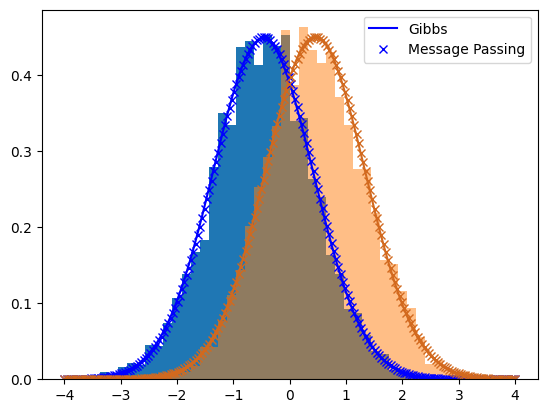

In [69]:
plt.hist(posterior[drops:,0], density=True, weights=post_weights[drops:,0], bins=50, range=(-4, 4))
plt.hist(posterior[drops:,1], density=True, weights=post_weights[drops:,1], bins=50, range=(-4, 4), alpha=0.5)

xs = np.linspace(-4, 4, 200)
gaussian1_gibbs = stats.norm(m1_gibbs, v1_gibbs**0.5).pdf(xs)
gaussian2_gibbs = stats.norm(m2_gibbs, v2_gibbs**0.5).pdf(xs)
plt.plot(xs, gaussian1_gibbs, color='blue', label='Gibbs')
plt.plot(xs, gaussian2_gibbs, color='chocolate')

gaussian1_mp = stats.norm(m1_mp, v1_mp**0.5).pdf(xs)
gaussian2_mp = stats.norm(m2_mp, v2_mp**0.5).pdf(xs)
plt.plot(xs, gaussian1_mp, 'x', color='blue', label='Message Passing')
plt.plot(xs, gaussian2_mp, 'x', color='chocolate')

plt.legend()